## Importing relevant libraries

In [2]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline
import itertools
from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import warnings
warnings.filterwarnings('ignore')

## Loading in the Train and Test Data

In [3]:
train_data= 'C:/Users/alaog/Downloads/archive (7)/Training'
filepaths=[]
labels=[]
folds=os.listdir(train_data)

for fold in folds:
    foldpath=os.path.join(train_data,fold)
    filelist=os.listdir(foldpath)
    
    for fpath in filelist:
        fillpath=os.path.join(foldpath,fpath)
        
        labels.append(fold)
        filepaths.append(fillpath)
        
file_series=pd.Series(filepaths,name='filepaths')
label_series=pd.Series(labels,name='labels')
train_df=pd.concat([file_series,label_series],axis=1)

In [4]:
train_df.head()

,filepaths,labels
0,C:/Users/alaog/Downloads/archive (7)/Training\...,glioma
1,C:/Users/alaog/Downloads/archive (7)/Training\...,glioma
2,C:/Users/alaog/Downloads/archive (7)/Training\...,glioma
3,C:/Users/alaog/Downloads/archive (7)/Training\...,glioma
4,C:/Users/alaog/Downloads/archive (7)/Training\...,glioma


In [5]:
test_data= 'C:/Users/alaog/Downloads/archive (7)/Testing'
filepaths=[]
labels=[]
folds=os.listdir(train_data)

for fold in folds:
    foldpath=os.path.join(test_data,fold)
    filelist=os.listdir(foldpath)
    
    for fpath in filelist:
        fillpath=os.path.join(foldpath,fpath)
        
        labels.append(fold)
        filepaths.append(fillpath)
        
file_series=pd.Series(filepaths,name='filepaths')
label_series=pd.Series(labels,name='labels')
test_df=pd.concat([file_series,label_series],axis=1)

In [6]:
test_df.head()

,filepaths,labels
0,C:/Users/alaog/Downloads/archive (7)/Testing\g...,glioma
1,C:/Users/alaog/Downloads/archive (7)/Testing\g...,glioma
2,C:/Users/alaog/Downloads/archive (7)/Testing\g...,glioma
3,C:/Users/alaog/Downloads/archive (7)/Testing\g...,glioma
4,C:/Users/alaog/Downloads/archive (7)/Testing\g...,glioma


## Preprocesing the Data

In [7]:
val_df, test_df= train_test_split(test_df,test_size=0.5,random_state= 43)

In [8]:
batch_size = 16
image_size = (224, 224)

train_gen = ImageDataGenerator()
test_gen = ImageDataGenerator()


train_generator = train_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= image_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

valid_generator = test_gen.flow_from_dataframe( val_df, x_col= 'filepaths', y_col= 'labels', target_size= image_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

test_generator = test_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= image_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= batch_size)

Found 5712 validated image filenames belonging to 4 classes.
Found 655 validated image filenames belonging to 4 classes.
Found 656 validated image filenames belonging to 4 classes.


## Show samples from training data

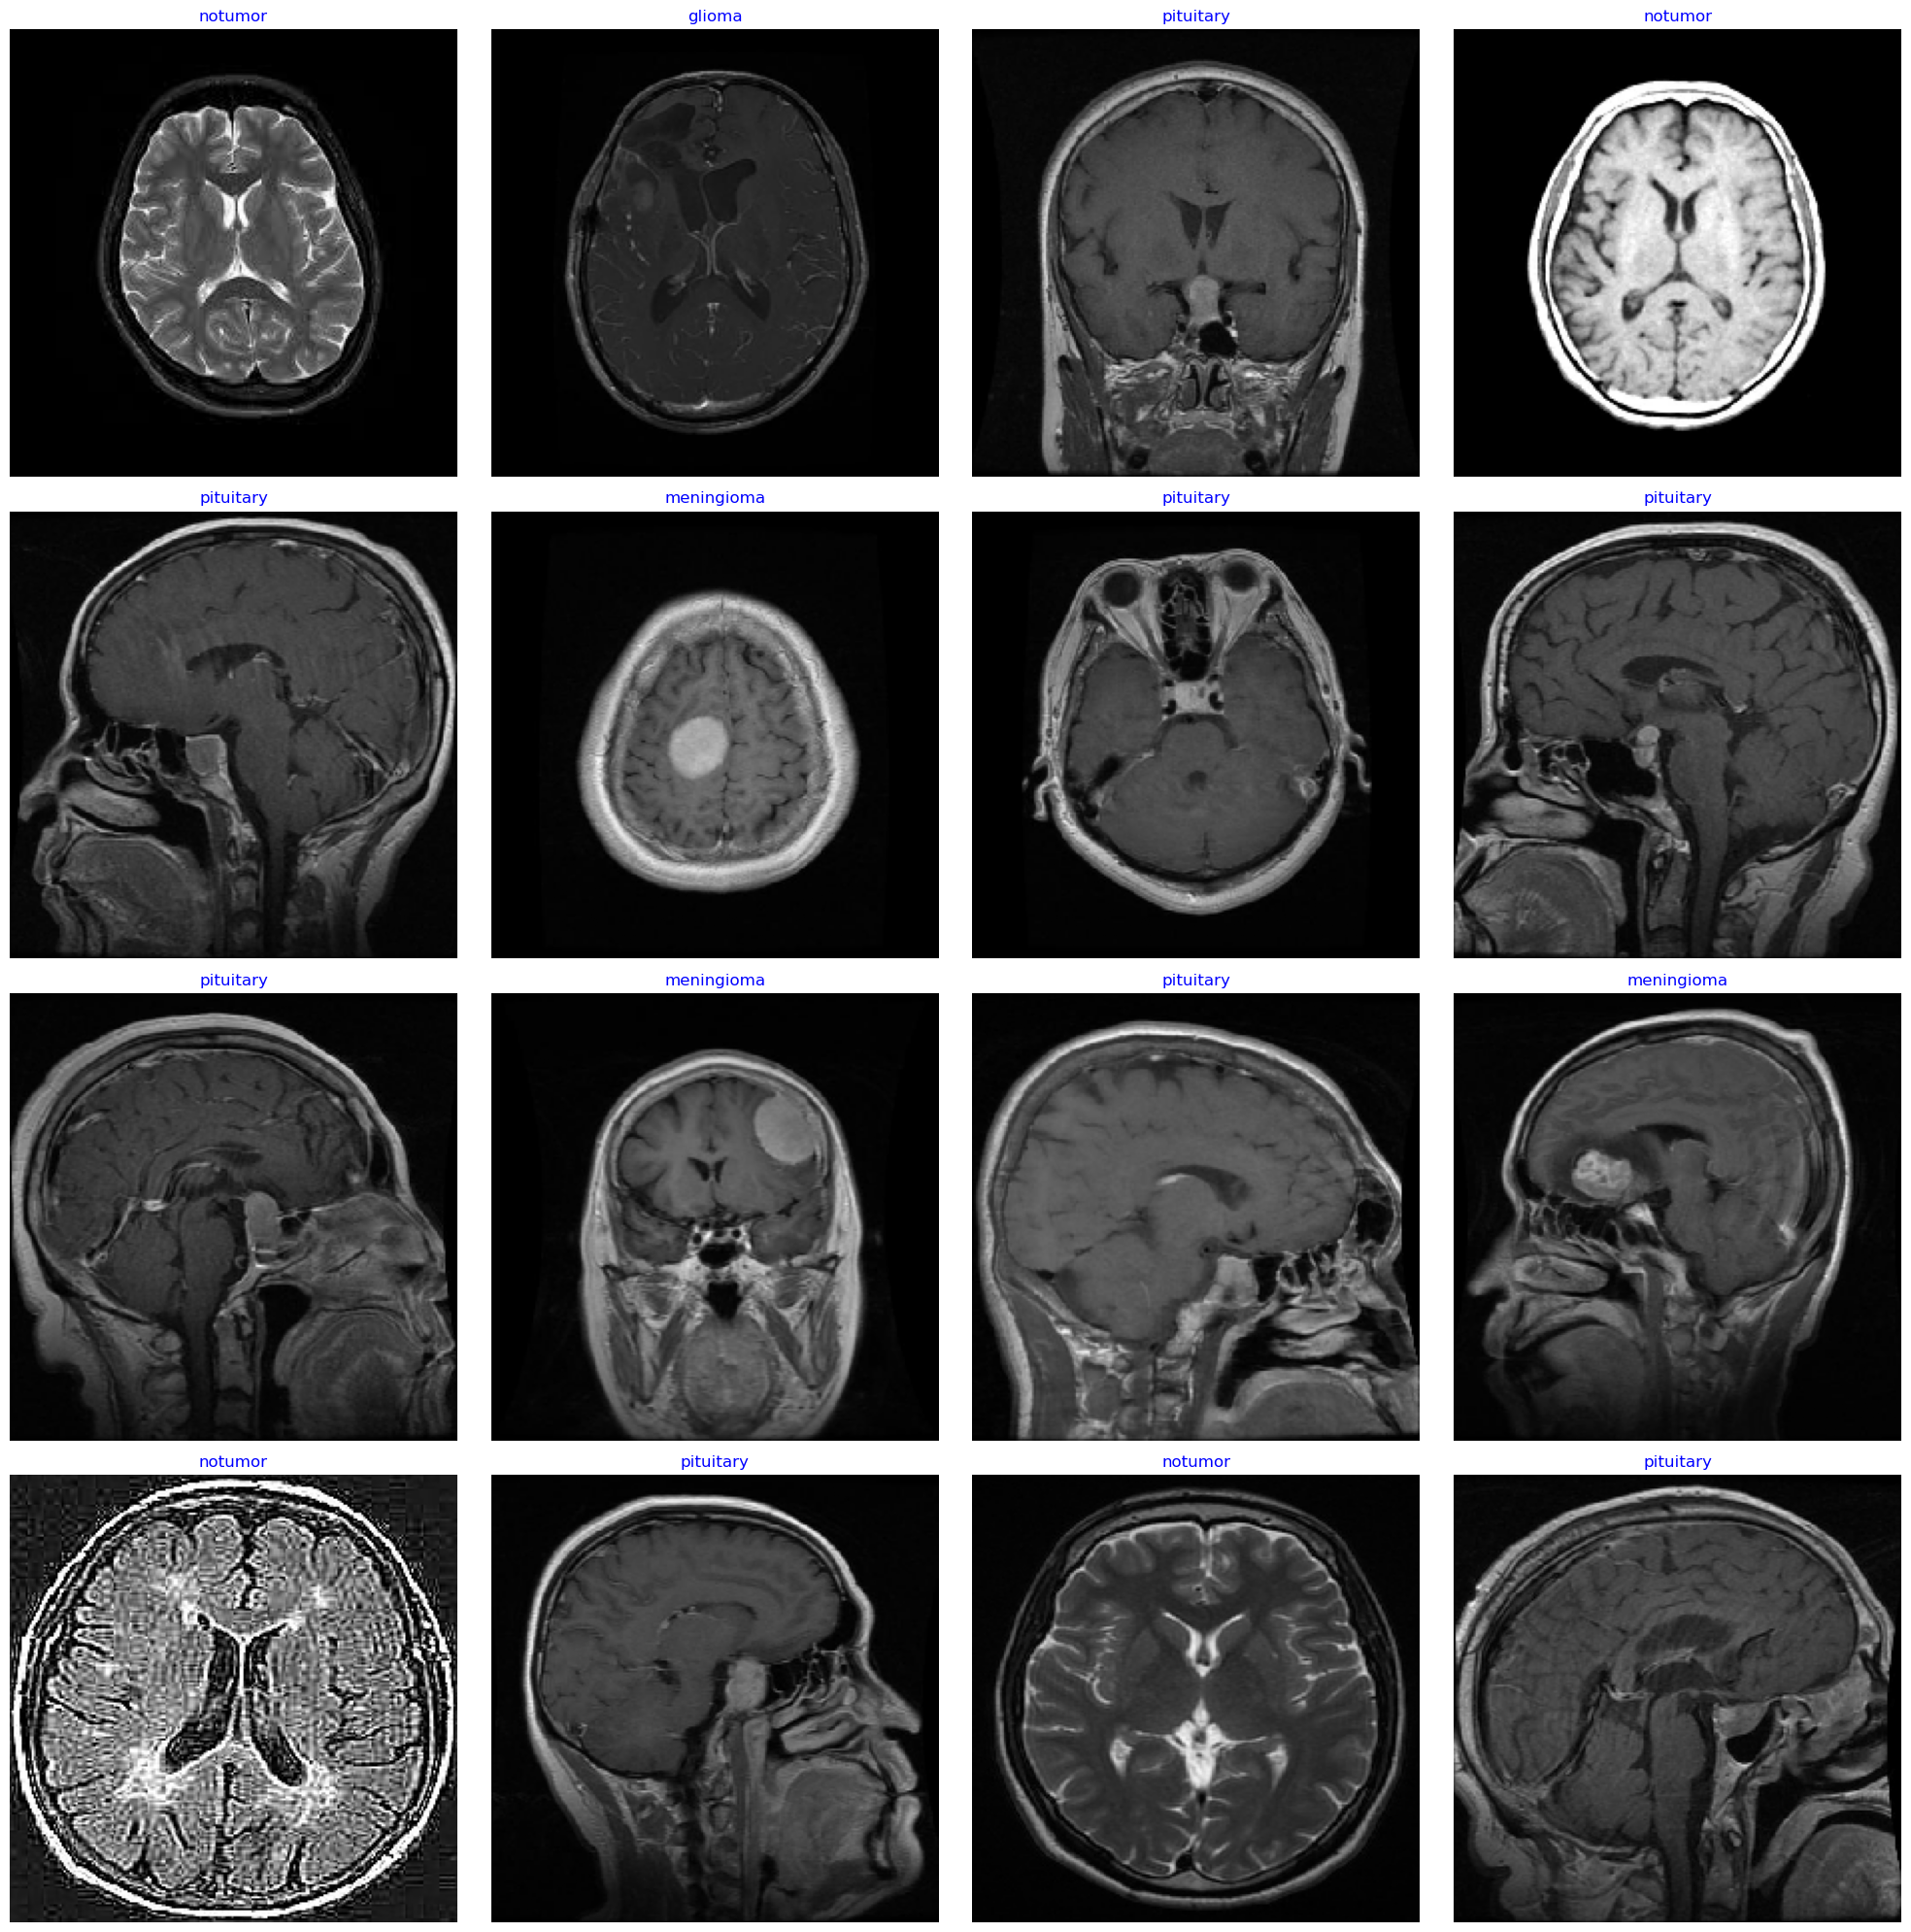

In [9]:
g_dict = train_generator.class_indices      # defines dictionary {'class': index}
classes = list(g_dict.keys())       # defines list of dictionary's kays (classes), classes names : string
images, labels = next(train_generator)      # get a batch size samples from the generator
# # difference between next iterator and for iterator


plt.figure(figsize= (20, 20))

for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255       # scales data to range (0 - 255)
    plt.imshow(image)
    index = np.argmax(labels[i])  # get image index
    class_name = classes[index]   # get class of image
    plt.title(class_name, color= 'blue', fontsize= 12)
    plt.axis('off')
plt.tight_layout()
plt.show()

In [10]:
# Print the class encodings done by the generators
class_map = dict([(v,k) for k, v in train_generator.class_indices.items()])
print(class_map)

{0: 'glioma', 1: 'meningioma', 2: 'notumor', 3: 'pituitary'}


## Building the Model

In [11]:
model = Sequential([
    # Note the input shape is the desired size of the image 224x224 with 3 bytes color
    # This is the first convolution
    Conv2D(16, (3,3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D(2, 2),
    # The second convolution
    Conv2D(32, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    # The third convolution
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    # The fourth convolution
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    # The fifth convolution
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    Flatten(),
    # 512 neuron hidden layer
    Dense(512, activation='relu'),
    Dense(4, activation='softmax') #4 output neurons representing the 4 classes in the dataset
])
                           
model.compile(optimizer = RMSprop(learning_rate=1e-4), loss= 'categorical_crossentropy', metrics= ['accuracy'])

## Training the Model

In [12]:
history = model.fit(train_generator, epochs= 10, verbose= 1, validation_data= valid_generator, shuffle= False)

Epoch 1/10
357/357 [==============================] - 105s 291ms/step - loss: 1.2655 - accuracy: 0.6677 - val_loss: 0.6870 - val_accuracy: 0.7267
Epoch 2/10
357/357 [==============================] - 88s 247ms/step - loss: 0.4432 - accuracy: 0.8284 - val_loss: 0.5170 - val_accuracy: 0.7908
Epoch 3/10
357/357 [==============================] - 92s 258ms/step - loss: 0.3012 - accuracy: 0.8895 - val_loss: 0.3809 - val_accuracy: 0.8565
Epoch 4/10
357/357 [==============================] - 92s 258ms/step - loss: 0.2175 - accuracy: 0.9216 - val_loss: 0.3632 - val_accuracy: 0.8687
Epoch 5/10
357/357 [==============================] - 90s 251ms/step - loss: 0.1576 - accuracy: 0.9452 - val_loss: 0.2758 - val_accuracy: 0.8962
Epoch 6/10
357/357 [==============================] - 89s 250ms/step - loss: 0.1099 - accuracy: 0.9629 - val_loss: 0.2562 - val_accuracy: 0.9221
Epoch 7/10
357/357 [==============================] - 90s 251ms/step - loss: 0.0775 - accuracy: 0.9736 - val_loss: 0.2182 - val_a

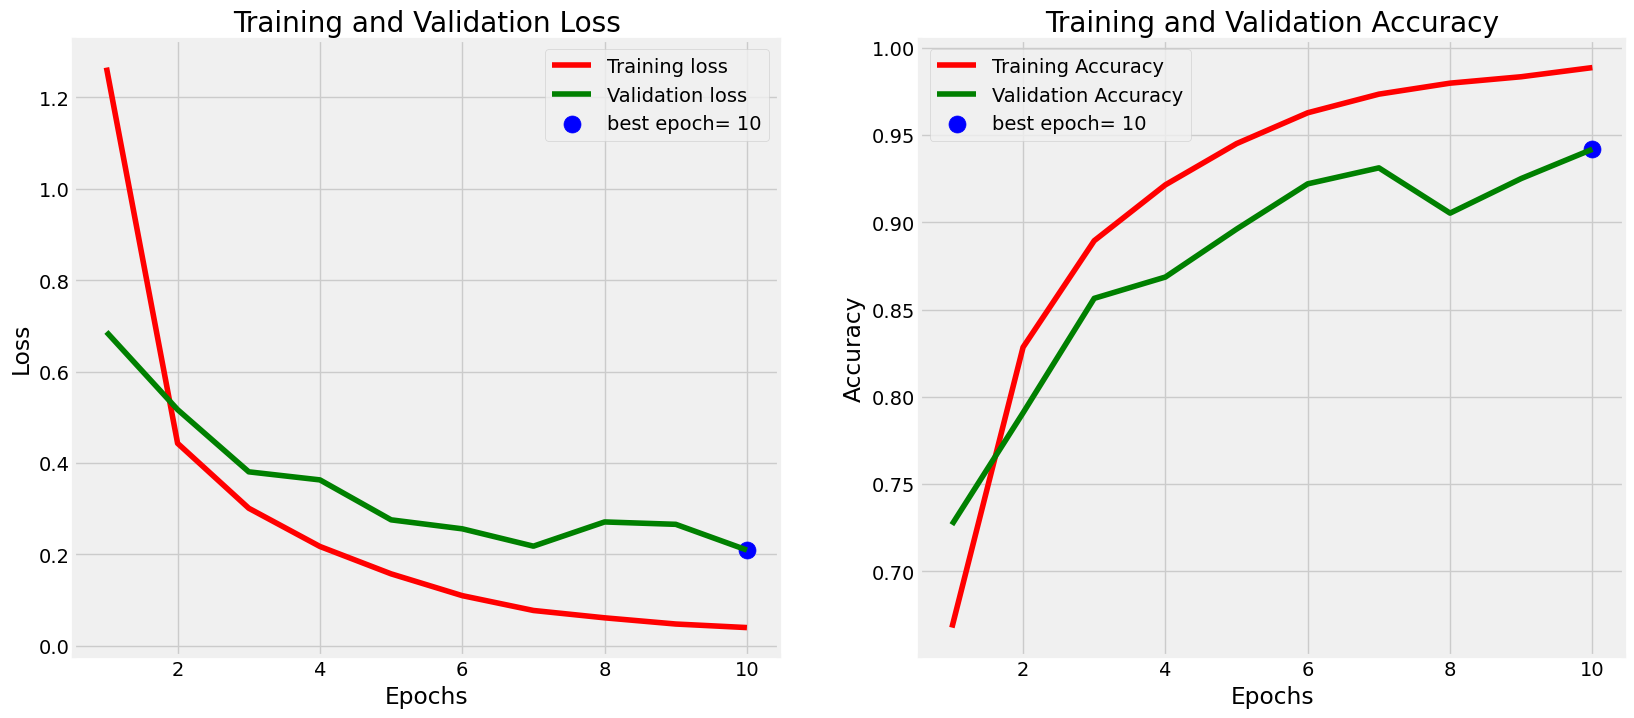

In [13]:
# Define needed variables
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]

Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

## Evaluating the Model

In [14]:
train_score = model.evaluate(train_generator, verbose= 1)
valid_score = model.evaluate(valid_generator, verbose= 1)
test_score = model.evaluate(test_generator, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

41/41 [==============================] - 7s 172ms/step - loss: 0.1720 - accuracy: 0.9466
Train Loss:  0.014319345355033875
Train Accuracy:  0.9961484670639038
--------------------
Validation Loss:  0.20970359444618225
Validation Accuracy:  0.9419847130775452
--------------------
Test Loss:  0.1719910204410553
Test Accuracy:  0.9466463327407837


## Getting Predictions

In [15]:
preds = model.predict(test_generator)  # [0.00001, 95.12312, 0.0021, 3.12313]
y_pred = np.argmax(preds, axis=1)

41/41 [==============================] - 3s 65ms/step


## Confusion Matrix

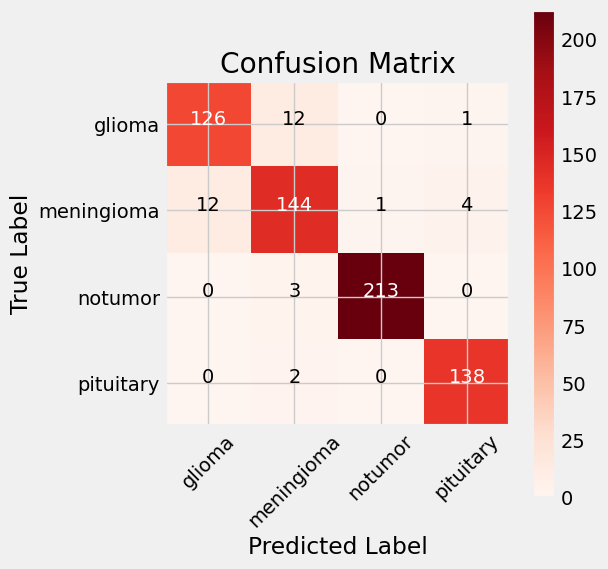

In [20]:
g_dict = test_generator.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_generator.classes, y_pred)
cm

plt.figure(figsize= (6, 6))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Reds)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')
    
plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

## Classification Report

In [17]:
print(classification_report(test_generator.classes, y_pred, target_names= classes))

              precision    recall  f1-score   support

      glioma       0.91      0.91      0.91       139
  meningioma       0.89      0.89      0.89       161
     notumor       1.00      0.99      0.99       216
   pituitary       0.97      0.99      0.98       140

    accuracy                           0.95       656
   macro avg       0.94      0.94      0.94       656
weighted avg       0.95      0.95      0.95       656

